# Observable 2

En este notebook se describen los análisis realizados sobre los espacios de parametros derivados del observable 2.

* esp 1: $\rho^{450}_{\mu}$ y $log(\sqrt{S_{rad}})$


* esp 2: $\dfrac{\rho^{450}_{\mu}}{log(\sqrt{S_{rad}})}$ y E$_{true}$


* esp 3: $\rho^{450}_{\mu}$, $log(\sqrt{S_{rad}})$ y E$_{true}$


* esp 4: $\rho^{450}_{\mu}$, $log(\sqrt{S_{rad}})$, E$_{true}$ y $\theta$


* esp 5: $\rho^{450}_{\mu}$, $log(\sqrt{S_{rad}})$, E$_{true}$, $\theta$ y estaciones de radio.

In [2]:
#Librerias importantes
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score,precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
import os

In [3]:
def MeritFactor(v1, v2):
    #Calculo de MF
    muF, stdF = norm.fit(v1)
    muP, stdP = norm.fit(v2)
    #muF, stdF = np.mean(v1), np.std(v1)
    #muP, stdP = np.mean(v2), np.std(v2)
    MF = np.abs(muF - muP) / (np.sqrt(pow(stdF,2) + pow(stdP,2)))
    return MF

In [4]:
def boostMF(v1, v2):
    vv=[]
    size=int(len(v1))
    for i in range(20000):
        #np.random.seed(seed=None)
        samplexF = np.random.choice(v1, size=int(size*0.90), replace=True)
        samplexP = np.random.choice(v2, size=int(size*0.90), replace=True)
        MF = MeritFactor(np.array(samplexP), np.array(samplexF))
        vv.append(np.abs(MF))
    
    avg, std = norm.fit(vv)
    return "%.2f"%avg, "%.2f"%std

In [5]:
# To plot pretty figures
import matplotlib as mpl
mpl.rc('axes', labelsize=22)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)

# Where to save the figures
PROJECT_ROOT_DIR = "/home/csarmiento/MEGA/phd_mega/analisisDeDatos/ML_MassComp/"
#CHAPTER_ID = "05_ModelosLineales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, figsize=(10,8))

In [6]:
#Función para calcular el accuracy
def accuracy(X, y, model):
    a=accuracy_score(y, model.predict(X))
    return a

In [7]:
#Función para calcular el accuracy via Cross-Val score
#Esto nos sirve para validar nuestro modelo sin usar los datos de test
def crossAccuracy(X, y, model):
    scoresGauTrain= cross_val_score(model, X, y, cv=10, scoring="accuracy");
    pres = cross_val_score(model, X, y, cv=10, scoring="precision");
    recl = cross_val_score(model, X, y, cv=10, scoring="recall");
    F1 = 2/((1/pres)+(1/recl))
    print("Accuracy: ", scoresGauTrain.mean(), scoresGauTrain.std())
    print("presicion: ", pres.mean(), pres.std())
    print("recall: ", recl.mean(), recl.std())
    print("F1_score: ", F1.mean(), F1.std())

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

def auc_cv(X, y, model):
    model = model
    X = np.array(X)
    y = np.array(y)
    random_state = np.random.RandomState(369)

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)

    tprs = []
    for i, (train, train) in enumerate(cv.split(X, y)):
        viz = roc_auc_score(y[train], model.predict_proba(X[train])[:, 1])
        tprs.append(viz)

    print(np.mean(tprs), np.std(tprs))

In [9]:
"""
Matriz de Confusion
Con MC podemos ver en detalle el comportamiento del modelo y saber cuantos eventos fueron mal clasificados.
Esta podría ser una mirada más realista que el accuracy.

>>> La precisión es definida como el ratio entre verdaderos positivos y número total 
de positivos predichos. Esto nos dice la fracción de los eventos que el modelo nos 
dice que son de la clase, realmente lo son.

>>> El recall o exhaustividad es definida como el es el ratio entre los verdaderos positivos 
y la suma de los verdaderos positivos y los falsos negativos. Esto nos dice la fracción
de los elementos de la clase encontró.
"""
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
def mconfusion(X, y, model):
    aux_pred = cross_val_predict(model, X, y, cv=10)
    cm = confusion_matrix(y, aux_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pres=tp/(tp + fp)
    exha=tp/(tp + fn)
    print("Matriz de confusión, \n"), print(cm), print("precisión: ", pres), print("exhaustividad: ", exha)

In [10]:
#Funcion para calcular la energia con GeoCeLDF
def GeoCeEnergy(RadEnergy, Alpha):
    d = 2.3137 * 1e14   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    c = 0.505
    E = d * pow(RadEnergy / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c)
    #return list(E)
    return np.array(E)
 
def GeoCeEnergyError(RadEnergy, RadEnergyError, Alpha):
    c = 0.505   #energy calibration parameters from Aab et al., PRD 93, 122005 (2016)
    errorE = pow(1 / ( np.sin((np.pi/180)*Alpha) * np.sin((np.pi/180)*Alpha)), c) * pow(RadEnergy, c - 1) * RadEnergyError
    return errorE

In [11]:
#A partir de aquí python sabe en que carpeta se encuentran los datos
os.chdir("/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData/")
os.getcwd()

'/home/csarmiento/MEGA/phd_mega/XmaxAnalysis/AnalisisXmax/newData'

In [12]:
#Cargando datos
df= pd.read_csv(r"CutEvents_IronRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")
dp= pd.read_csv(r"CutEvents_ProtonRefDist_Sd140_Filter_MdRd_e.txt", delimiter="\t")

In [13]:
print(df.shape, dp.shape)

(305, 59) (305, 59)


In [14]:
#angulo alfa
AlphaFe=df['lorentz angle']
AlphaFe=np.array(AlphaFe)
AlphaPr=dp['lorentz angle']
AlphaPr=np.array(AlphaPr)

#radiation energy
RadEGeoCeFe=df['GeoCe Erad']
RadEGeoCeFe=np.array(RadEGeoCeFe)
RadEGeoCePr=dp['GeoCe Erad']
RadEGeoCePr=np.array(RadEGeoCePr)

#radiation energy error
RadEGeoCeFe_err=df['GeoCe Erad Error']
RadEGeoCeFe_err=np.array(RadEGeoCeFe_err)
RadEGeoCePr_err=dp['GeoCe Erad Error']
RadEGeoCePr_err=np.array(RadEGeoCePr_err)

#Energia Rd
GeoCeEnergyFe=GeoCeEnergy(RadEGeoCeFe,AlphaFe)
GeoCeEnergyFe_err=GeoCeEnergyError(RadEGeoCeFe, RadEGeoCeFe_err, AlphaFe)
GeoCeEnergyPr=GeoCeEnergy(RadEGeoCePr,AlphaPr)
GeoCeEnergyPr_err=GeoCeEnergyError(RadEGeoCePr,RadEGeoCePr_err, AlphaPr)

df["EnergyRd"] = GeoCeEnergyFe
dp["EnergyRd"] = GeoCeEnergyPr

In [15]:
#Inclusion del target

df["Mu_LogSrad"] = df["N_mu_ref"]/np.log10(np.sqrt(df["GeoCe Erad"]))
dp["Mu_LogSrad"] = dp["N_mu_ref"]/np.log10(np.sqrt(dp["GeoCe Erad"]))

df["LogSrad"] = np.log10(np.sqrt(df["GeoCe Erad"]))
dp["LogSrad"] = np.log10(np.sqrt(dp["GeoCe Erad"]))

df["target"] = df["Rd rec success"]
dp["target"] = dp["Rd rec success"]*0

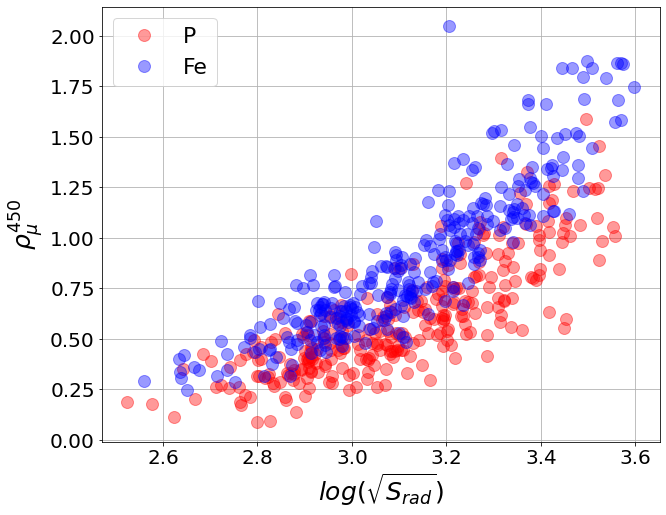

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(np.log10(np.sqrt(df["GeoCe Erad"])), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.log10(np.sqrt(dp["GeoCe Erad"])), df['N_mu_ref'],  'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()
plt.show()

<AxesSubplot:>

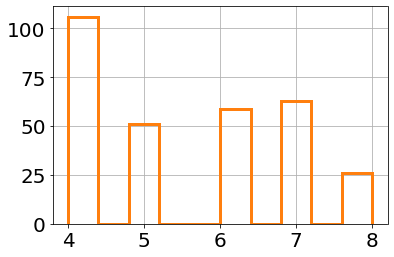

In [17]:
#Iron
df["antennas_cut"] = pd.cut(df["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

df["antennas_cut"].hist(histtype='step',linewidth=3, label="Antenas")

#Proton

dp["antennas_cut"] = pd.cut(dp["MC energy"],
                               bins=[0.1E18, 0.35E18, 0.45E18, 0.6E18, 0.9E18, np.inf],
                               labels=[4, 5, 6, 7, 8])

dp["antennas_cut"].hist(histtype='step',linewidth=3, label="Antenas")

In [18]:
df["antennas_cut"].value_counts()

4    106
7     63
6     59
5     51
8     26
Name: antennas_cut, dtype: int64

In [19]:
#### Iron

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=224466)
for train_index, test_index in split.split(df, df["antennas_cut"]):
    train_set_fe = df.loc[train_index]
    test_set_fe = df.loc[test_index]
    
train_set_fe=train_set_fe.drop(["antennas_cut"], axis=1)
test_set_fe=test_set_fe.drop(["antennas_cut"], axis=1)
print(train_set_fe.shape, test_set_fe.shape)

(244, 63) (61, 63)


In [20]:
#### Proton

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(dp, dp["antennas_cut"]):
    train_set_pr = dp.loc[train_index]
    test_set_pr = dp.loc[test_index]
    
train_set_pr=train_set_pr.drop(["antennas_cut"], axis=1)
test_set_pr=test_set_pr.drop(["antennas_cut"], axis=1)
print(train_set_pr.shape, test_set_pr.shape)

(244, 63) (61, 63)


In [21]:
### Contanetando data set
f_train = [train_set_fe, train_set_pr]
f_test = [test_set_fe, test_set_pr]

df_train_ = pd.concat(f_train)
df_test_ = pd.concat(f_test)

print(df_train_.shape, df_test_.shape)
df_train_.head()

(488, 63) (122, 63)


,runnr,MC energy,MC zenith,MC azimuth,MC Xmax,MC core x,MC core y,MC core z,Sd rec success,Sd energy,...,MLDF NDF,MLDF Likelihood,M beta,M beta error,M beta syst,pvalueMd,EnergyRd,Mu_LogSrad,LogSrad,target
246,104205,3.824250e+17,50.0277,332.231,606.878,449654,6113980.0,1468.62,1,3.718930e+17,...,15,10.3269,0.625931,0.309216,0,0.342569,2.963127e+17,0.276681,3.074320,1
76,101420,7.590210e+17,50.6696,252.789,615.647,448851,6114320.0,1478.28,1,5.112060e+17,...,26,17.2197,0.964079,0.189909,0,0.304324,5.784101e+17,0.332348,3.352450,1
171,102730,6.116010e+17,40.6307,285.853,616.988,449204,6114370.0,1473.42,1,4.199210e+17,...,24,17.0630,0.588354,0.280413,0,0.328039,4.665071e+17,0.350593,3.271228,1
191,103178,3.842740e+17,53.6568,218.822,601.143,450980,6114150.0,1460.45,1,2.665860e+17,...,15,10.9482,0.000097,2.893310,0,0.445807,3.314039e+17,0.196055,3.122918,1
75,101416,9.452550e+17,49.0955,355.084,636.076,449628,6113950.0,1467.00,1,6.682260e+17,...,27,10.3834,1.490790,0.183751,0,0.765089,7.529746e+17,0.357259,3.448698,1


In [22]:
df_train = df_train_.copy()
df_test = df_test_.copy()

In [23]:
#Features

df_train_1 = df_train[["LogSrad", "N_mu_ref", "target"]]
df_test_1 = df_test[["LogSrad", "N_mu_ref", "target"]]

In [24]:
print(df_train_1.shape, df_test_1.shape)

(488, 3) (122, 3)


In [25]:
df_train_1.head()

,LogSrad,N_mu_ref,target
246,3.074320,0.850606,1
76,3.352450,1.114180,1
171,3.271228,1.146870,1
191,3.122918,0.612265,1
75,3.448698,1.232080,1


In [26]:
corr_matrix = df_train_1.corr()
corr_matrix["target"].sort_values(ascending=False)

target      1.000000
N_mu_ref    0.384449
LogSrad    -0.060095
Name: target, dtype: float64

In [27]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_1.drop("target", axis=1) 
df_train_labels = df_train_1["target"].copy()

df_test_aux = df_test_1.drop("target", axis=1) 
df_test_labels = df_test_1["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_test_aux.shape, df_test_labels.shape)

(488, 2) (488,) (122, 2) (122,)


In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [29]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [30]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [32]:
X_train.head()

,LogSrad,N_mu_ref
0,-0.187830,0.462230
1,1.099993,1.066291
2,0.723505,1.133262
3,0.036905,-0.224563
4,1.546554,1.301173


In [33]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

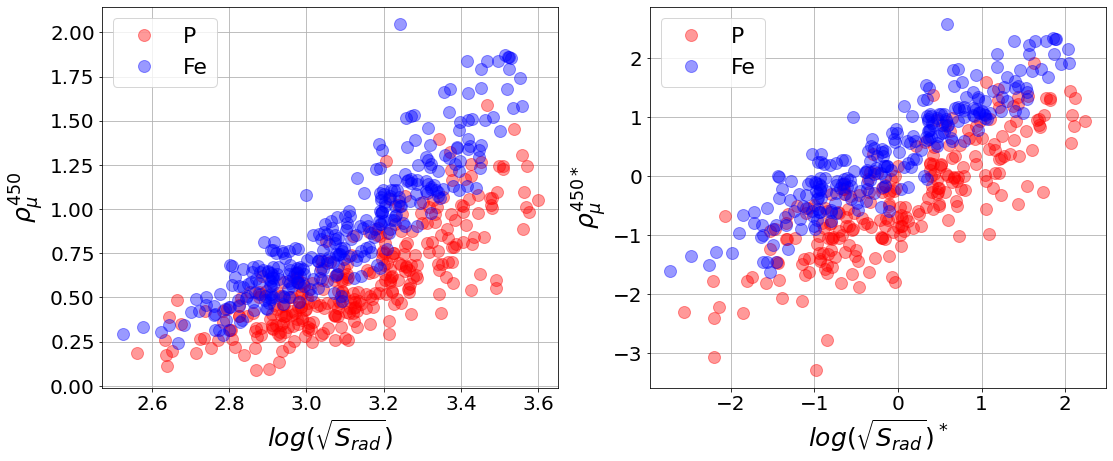

In [34]:
plt.figure(figsize=(18, 7))


plt.subplot(121)
plt.plot(np.log10(np.sqrt(dp["GeoCe Erad"])), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(np.log10(np.sqrt(df["GeoCe Erad"])), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

plt.subplot(122)
plt.plot(XX[yy==0, 0], XX[yy==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
plt.xlabel(r"$log(\sqrt{S_{rad}})^*$", fontsize=25)
plt.ylabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
#plt.xlim(17.1, 18.1)
#plt.ylim(None, 0.0035)
plt.legend(fontsize=22)
plt.grid()

In [35]:
def escala(method):
    
    Xss=XX
    y=yy

    plt.figure(figsize=(18, 22))

    plt.subplot(321)
    plt.plot(np.log10(np.sqrt(dp["GeoCe Erad"])), dp['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(np.log10(np.sqrt(df["GeoCe Erad"])), df['N_mu_ref'], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
    plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    #plt.text(480, 0.0011, "(a)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(322)
    plt.plot(Xss[yy==0, 0], Xss[yy==0, 1], 'o', alpha=0.4, markersize=12, color="r", label="P")
    plt.plot(Xss[yy==1, 0], Xss[yy==1, 1], 'o', alpha=0.4, markersize=12, color="b", label="Fe")
    plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
    #plt.text(-2.5, 2.5, "(b)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()

    plt.subplot(323)
    bins = np.linspace(2, 5, 25)
    plt.hist(np.log10(np.sqrt(dp["GeoCe Erad"])), bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(np.log10(np.sqrt(df["GeoCe Erad"])), bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
    #plt.text(500, 65, "(c)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()    
    
    
    plt.subplot(324)
    bins = np.linspace(-4, 4, 25)
    plt.hist(Xss[y==0, 0], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 0], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$log(\sqrt{S_{rad}})^*$", fontsize=25)
    #plt.text(-2.5, 45, "(d)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    
    plt.subplot(325)
    bins = np.linspace(0, 4, 20)
    plt.hist(dp['N_mu_ref'], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(df['N_mu_ref'], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450}_{\mu}$", fontsize=25)
    plt.legend(fontsize=22)
    #plt.text(1.2E-4, 65, "(e)", c='k', fontsize=35)
    plt.grid()
    
    plt.subplot(326)
    bins = np.linspace(-4, 4, 18)
    plt.hist(Xss[y==0, 1], bins, histtype='step', linewidth=3, color='r', label="P");
    plt.hist(Xss[y==1, 1], bins, histtype='step', linewidth=3, color='b', label="Fe");
    plt.xlabel(r"$\rho^{450*}_{\mu}$", fontsize=25)
    #plt.text(-2.5, 47.5, "(f)", c='k', fontsize=35)
    plt.legend(fontsize=22)
    plt.grid()
    

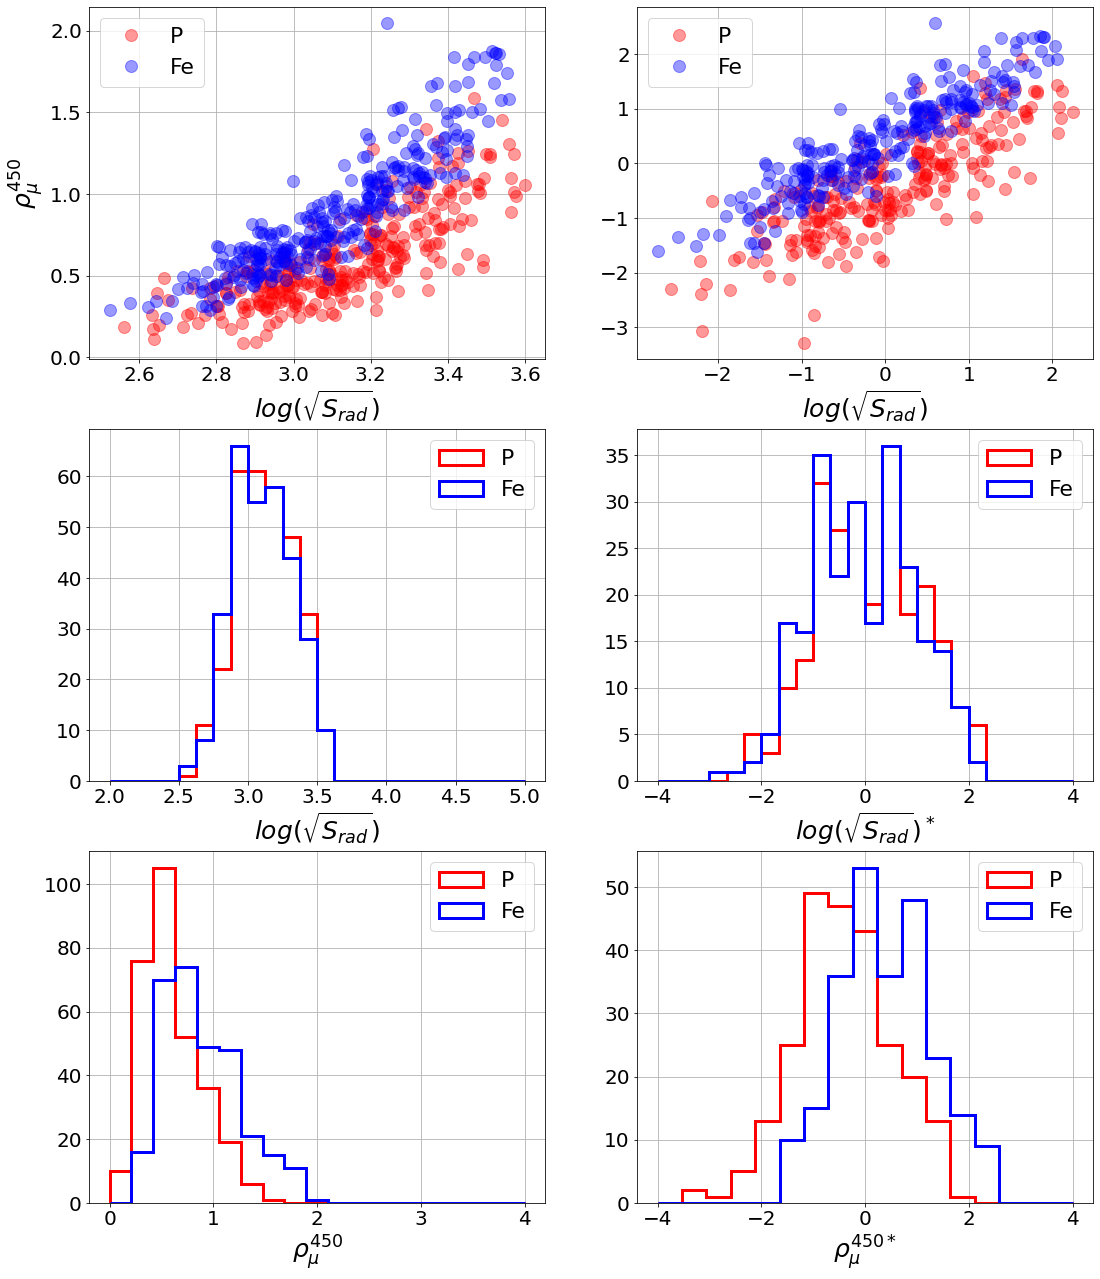

In [36]:
escala(PowerTransformer(method='box-cox'))

In [37]:
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [37]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [38]:
model_Log_1 = rnd_search_cv.best_estimator_
model_Log_1

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=35.87659025451008, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [39]:
print(accuracy(X_train, y_train, model_Log_1))
print(crossAccuracy(X_train, y_train, model_Log_1))

0.8545081967213115
Accuracy:  0.8484268707482994 0.0729136916550629
presicion:  0.8365375996372999 0.07018495718112613
recall:  0.8690000000000001 0.09680507332894399
F1_score:  0.850656359327709 0.07512308869998632
None


In [40]:
mconfusion(X_train, y_train, model_Log_1)

Matriz de confusión, 

[[202  42]
 [ 32 212]]
precisión:  0.8346456692913385
exhaustividad:  0.8688524590163934


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       244
           1       0.84      0.88      0.86       244

    accuracy                           0.85       488
   macro avg       0.86      0.85      0.85       488
weighted avg       0.86      0.85      0.85       488



In [42]:
ypred = cross_val_predict(model_Log_1, X_train, y_train, cv=5, method="decision_function")

In [43]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

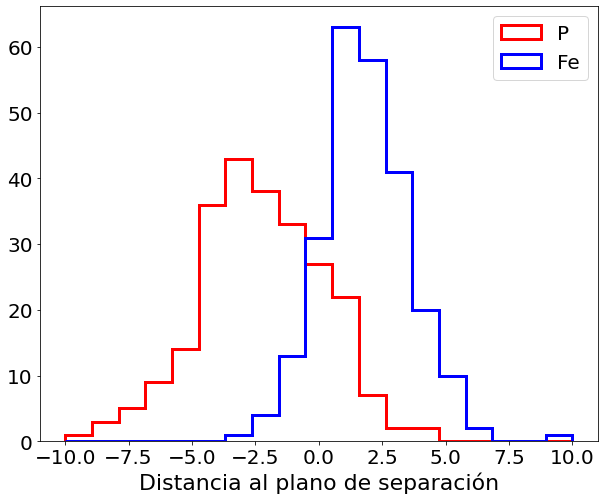

In [44]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [45]:
boostMF(c1_pred, c2_pred)

('1.37', '0.08')

In [46]:
lr=model_Log_1.named_steps['logi_clf']

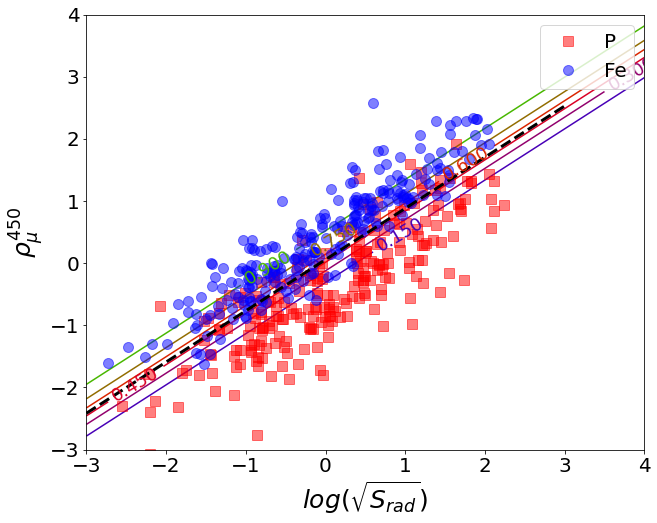

In [47]:
log_reg = model_Log_1.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-3, 4, 500).reshape(-1, 1),
        np.linspace(-3, 4, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)
plt.axis([-3, 4, -3, 4])
#save_fig("plano_reglog_plot")
plt.show()

In [48]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [50]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [51]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [52]:
model_Log_2 = rnd_search_cv.best_estimator_
model_Log_2

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=2.597352825618803, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [53]:
print(accuracy(X_poly2, y_train, model_Log_2))
print(crossAccuracy(X_poly2, y_train, model_Log_2))

0.8545081967213115
Accuracy:  0.8422619047619048 0.06552034909896509
presicion:  0.8172549487549488 0.061476020721603956
recall:  0.8855000000000001 0.08285881566455881
F1_score:  0.8486265640934316 0.06420700816060201
None


In [54]:
mconfusion(X_poly2, y_train, model_Log_2)

Matriz de confusión, 

[[195  49]
 [ 28 216]]
precisión:  0.8150943396226416
exhaustividad:  0.8852459016393442


In [55]:
print(classification_report(y_train, model_Log_2.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       244
           1       0.83      0.89      0.86       244

    accuracy                           0.85       488
   macro avg       0.86      0.85      0.85       488
weighted avg       0.86      0.85      0.85       488



In [56]:
ypred = cross_val_predict(model_Log_1, X_poly2, y_train, cv=5, method="decision_function")

In [57]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

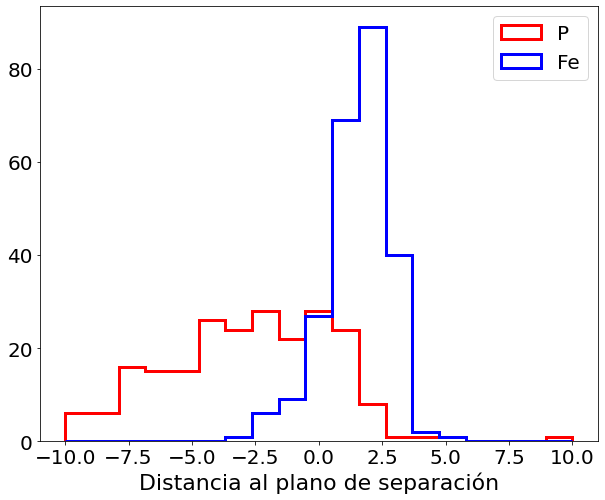

In [58]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [59]:
boostMF(c1_pred, c2_pred)

('0.94', '0.10')

## SVM

In [60]:
from sklearn import svm

In [61]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [62]:
model_svm_1 = rnd_search_cv.best_estimator_
model_svm_1

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=96.3105958551011, break_ties=False, cache_size=200,
                     class_weight=None, coef0=65.94836607023763,
                     decision_function_shape='ovr', degree=3,
                     gamma=2.954328927609265e-05, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [63]:
print(accuracy(X_train, y_train, model_svm_1))
print(crossAccuracy(X_train, y_train, model_svm_1))

0.8524590163934426
Accuracy:  0.8443452380952381 0.07173072682427695
presicion:  0.8214780682150948 0.07344557669909778
recall:  0.8855000000000001 0.08285881566455881
F1_score:  0.8507980750396016 0.0694030632512907
None


In [64]:
mconfusion(X_train, y_train, model_svm_1)

Matriz de confusión, 

[[196  48]
 [ 28 216]]
precisión:  0.8181818181818182
exhaustividad:  0.8852459016393442


In [65]:
print(classification_report(y_train, model_svm_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       244
           1       0.83      0.89      0.86       244

    accuracy                           0.85       488
   macro avg       0.85      0.85      0.85       488
weighted avg       0.85      0.85      0.85       488



In [66]:
ypred = cross_val_predict(model_svm_1, X_train, y_train, cv=5, method="decision_function")

In [67]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

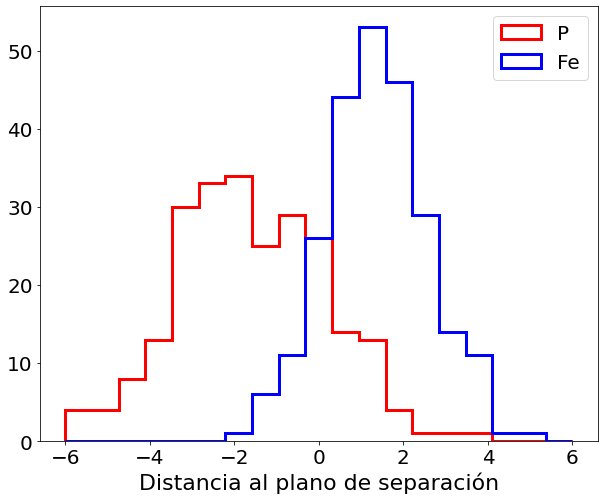

In [68]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [69]:
boostMF(c1_pred, c2_pred)

('1.37', '0.08')

In [70]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=100, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=100, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,

In [71]:
model_svm_1p = rnd_search_cv.best_estimator_
model_svm_1p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=2.6242969183812193, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [72]:
print(accuracy(X_train, y_train, model_svm_1p))
print(crossAccuracy(X_train, y_train, model_svm_1p))

0.8360655737704918
Accuracy:  0.8177295918367348 0.0770691675131494
presicion:  0.7797377237367096 0.0859362536381908
recall:  0.9020000000000001 0.07450876160261662
F1_score:  0.8337761936101963 0.06791377702483009
None


In [73]:
mconfusion(X_train, y_train, model_svm_1p)

Matriz de confusión, 

[[179  65]
 [ 24 220]]
precisión:  0.7719298245614035
exhaustividad:  0.9016393442622951


In [74]:
print(classification_report(y_train, model_svm_1p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       244
           1       0.79      0.91      0.85       244

    accuracy                           0.84       488
   macro avg       0.84      0.84      0.84       488
weighted avg       0.84      0.84      0.84       488



In [75]:
ypred = cross_val_predict(model_svm_1p, X_train, y_train, cv=5, method="decision_function")

In [76]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

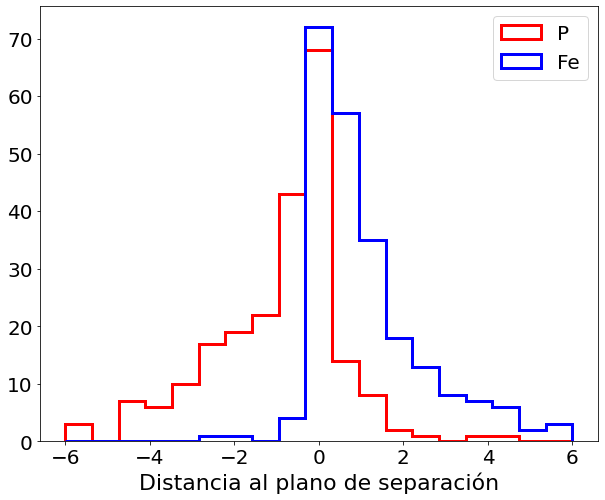

In [77]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [78]:
boostMF(c1_pred, c2_pred)

('0.69', '0.07')

In [79]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [80]:
model_svm_2 = rnd_search_cv.best_estimator_
model_svm_2

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=7.932959576602051, break_ties=False, cache_size=200,
                     class_weight=None, coef0=39.63060041672601,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.004707526954197245, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [81]:
print(accuracy(X_train, y_train, model_svm_2))
print(crossAccuracy(X_train, y_train, model_svm_2))

0.8483606557377049
Accuracy:  0.8504251700680273 0.05869497042700347
presicion:  0.8129150823633584 0.05438178037590003
recall:  0.9141666666666668 0.06880830860683419
F1_score:  0.8596389865111975 0.05472400619556646
None


In [82]:
mconfusion(X_train, y_train, model_svm_2)

Matriz de confusión, 

[[192  52]
 [ 21 223]]
precisión:  0.8109090909090909
exhaustividad:  0.9139344262295082


In [83]:
print(classification_report(y_train, model_svm_2.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       244
           1       0.81      0.91      0.86       244

    accuracy                           0.85       488
   macro avg       0.85      0.85      0.85       488
weighted avg       0.85      0.85      0.85       488



In [84]:
ypred = cross_val_predict(model_svm_2, X_train, y_train, cv=5, method="decision_function")

In [85]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

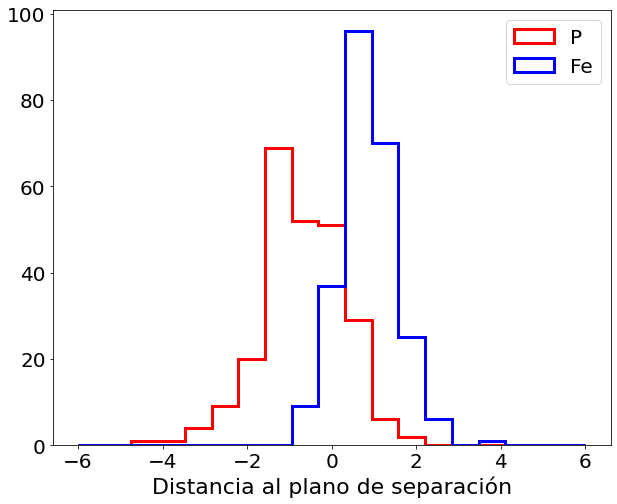

In [86]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [87]:
boostMF(c1_pred, c2_pred)

('1.37', '0.08')

In [88]:
svcP=model_svm_2.named_steps['svm_clf']

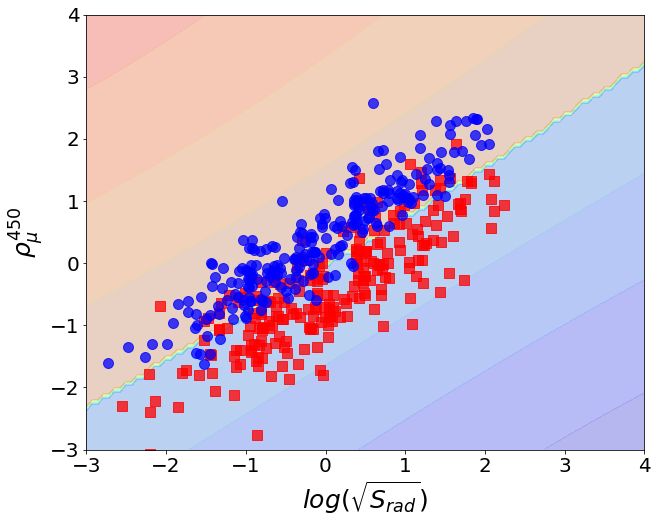

In [89]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model_svm_2.predict(X).reshape(x0.shape)
    y_decision = model_svm_2.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_2,[-3, 4, -3, 7])
plot_dataset(XX, yy,[-3, 4, -3, 4])
plt.xlabel(r"$log(\sqrt{S_{rad}})$", fontsize=25)
plt.ylabel(r"$\rho^{450}_{\mu}$", fontsize=25)

plt.show()

## Incluyendo la energía

In [324]:
#Features

df_train_2 = df_train[["MC energy", "Mu_LogSrad", "target"]]
df_test_2 = df_test[["MC energy", "Mu_LogSrad", "target"]]

In [325]:
print(df_train_2.shape, df_test_.shape)

(488, 3) (122, 63)


In [326]:
df_train_2.head()

,MC energy,Mu_LogSrad,target
246,3.824250e+17,0.276681,1
76,7.590210e+17,0.332348,1
171,6.116010e+17,0.350593,1
191,3.842740e+17,0.196055,1
75,9.452550e+17,0.357259,1


In [327]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target        1.000000
Mu_LogSrad    0.441245
MC energy    -0.005095
Name: target, dtype: float64

In [328]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 2) (488,) (488, 2) (122,)


In [329]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [330]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [331]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 2) (122, 2) (488,) (122,)


In [332]:
X_train.head()

,MC energy,Mu_LogSrad
0,-0.324464,0.546207
1,1.092195,1.012950
2,0.651643,1.153904
3,-0.314309,-0.264631
4,1.534527,1.204120


In [337]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [338]:
model_Log_3 = rnd_search_cv.best_estimator_
model_Log_3

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.050314744994473, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [339]:
print(accuracy(X_train, y_train, model_Log_3))
print(crossAccuracy(X_train, y_train, model_Log_1))

0.875
Accuracy:  0.8668792517006804 0.04876404127180039
presicion:  0.8574182194616977 0.047972320830461976
recall:  0.8811666666666668 0.053307545849011324
F1_score:  0.8688039808456501 0.04787782541898011
None


In [340]:
print(crossAccuracy(X_test, y_test, model_Log_1))

Accuracy:  0.8371794871794872 0.11535612183796912
presicion:  0.8411904761904763 0.12669731995726563
recall:  0.8357142857142857 0.14924222804014114
F1_score:  0.833962703962704 0.12437980526495665
None


In [341]:
mconfusion(X_train, y_train, model_Log_3)

Matriz de confusión, 

[[208  36]
 [ 25 219]]
precisión:  0.8588235294117647
exhaustividad:  0.8975409836065574


In [342]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_3.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       244
           1       0.86      0.90      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [343]:
ypred = cross_val_predict(model_Log_3, X_train, y_train, cv=5, method="decision_function")

In [344]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

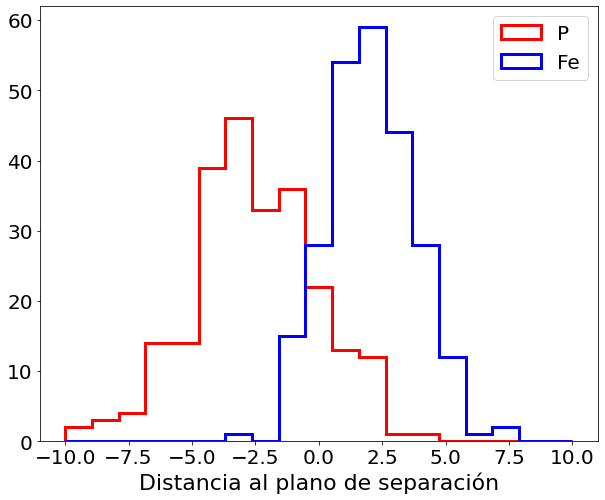

In [345]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [346]:
boostMF(c1_pred, c2_pred)

('1.51', '0.08')

In [108]:
lr=model_Log_3.named_steps['logi_clf']

In [109]:
XX=X_train.select_dtypes(include=float).to_numpy()
yy=y_train

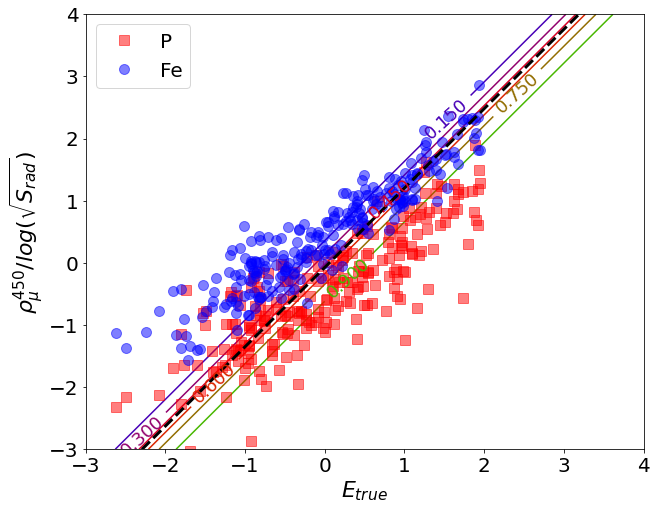

In [110]:
X=X_train
y=y_train

log_reg = model_Log_3.named_steps['logi_clf']

x0, x1 = np.meshgrid(
        np.linspace(-3, 4, 500).reshape(-1, 1),
        np.linspace(-3, 4, 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 8))
plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.5, label="P")
plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.5, label="Fe")

plt.legend(fontsize=20)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x1, x0, zz, cmap=plt.cm.brg)


left_right = np.array([-3, 4])
boundary = -(log_reg.coef_[0][1] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][0]

plt.clabel(contour, inline=1, fontsize=18)
plt.plot(left_right, boundary, "k--", linewidth=3)
#plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
#plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel(r"$E_{true}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / log(\sqrt{S_{rad}})$", fontsize=22)
plt.axis([-3, 4, -3, 4])
#save_fig("plano_reglog_plot")
plt.show()

In [111]:
from sklearn.preprocessing import PolynomialFeatures

In [112]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 9)

In [113]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 9)

In [114]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 10)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [115]:
model_Log_4 = rnd_search_cv.best_estimator_
model_Log_4

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=3.9953953423952773, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [116]:
print(accuracy(X_poly2, y_train, model_Log_4))
print(crossAccuracy(X_poly2, y_train, model_Log_4))

0.8770491803278688
Accuracy:  0.875 0.05171857907142373
presicion:  0.8573617027927372 0.051176944551862044
recall:  0.9016666666666666 0.061734197258173786
F1_score:  0.8782372549911827 0.0512859145793295
None


In [117]:
mconfusion(X_poly2, y_train, model_Log_4)

Matriz de confusión, 

[[207  37]
 [ 24 220]]
precisión:  0.8560311284046692
exhaustividad:  0.9016393442622951


In [118]:
print(classification_report(y_train, model_Log_4.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [119]:
ypred = cross_val_predict(model_Log_4, X_poly2, y_train, cv=5, method="decision_function")

In [120]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

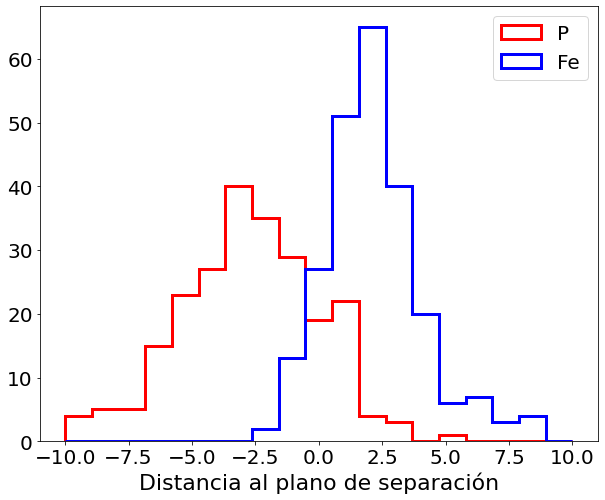

In [121]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [122]:
boostMF(c1_pred, c2_pred)

('1.24', '0.08')

## SVM Energia

In [65]:
from sklearn import svm

In [66]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [67]:
model_svm_3 = rnd_search_cv.best_estimator_
model_svm_3

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=9.679582543995418, break_ties=False, cache_size=200,
                     class_weight=None, coef0=470.60115443177165,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.007191386958238059, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [68]:
print(accuracy(X_train, y_train, model_svm_3))
print(crossAccuracy(X_train, y_train, model_svm_3))

0.8524590163934426
Accuracy:  0.8443452380952381 0.07173072682427695
presicion:  0.8200117925552709 0.07514562612783911
recall:  0.8895 0.08535562859784547
F1_score:  0.8514138385863996 0.06916667067273294
None


In [69]:
auc_cv(X_train, y_train, model_svm_3)

0.9197291666666668 0.04309380525448788


In [70]:
print(crossAccuracy(X_test, y_test, model_svm_3))

Accuracy:  0.8301282051282051 0.10677455404350795
presicion:  0.8211904761904762 0.11532488860594137
recall:  0.869047619047619 0.12428936320131609
F1_score:  0.8375379522438345 0.09636675387711069
None


In [71]:
auc_cv(X_test, y_test, model_svm_3)

0.9126984126984128 0.08186537751255632


In [72]:
mconfusion(X_train, y_train, model_svm_3)

Matriz de confusión, 

[[195  49]
 [ 27 217]]
precisión:  0.8157894736842105
exhaustividad:  0.889344262295082


In [73]:
print(classification_report(y_train, model_svm_3.predict(X_train)))

NameError: name 'classification_report' is not defined

In [ ]:
ypred = cross_val_predict(model_svm_3, X_train, y_train, cv=5, method="decision_function")

In [ ]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

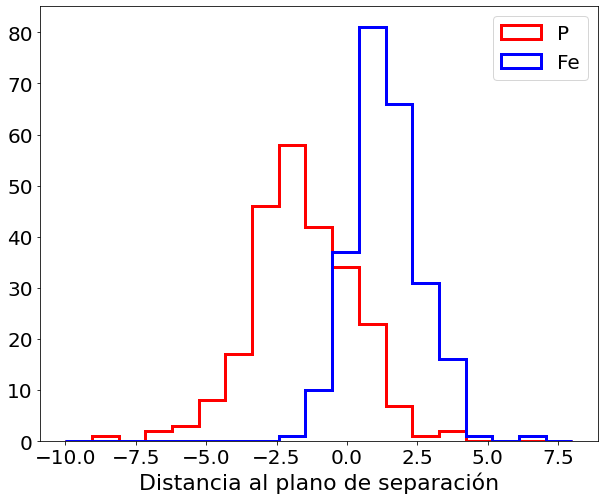

In [74]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 8, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)
#save_fig("obs_2_hist_best")
plt.show()

In [75]:
boostMF(c1_pred, c2_pred)

('1.38', '0.08')

Saving figure plano_SVM_plot_best_ obs_2


/home/csarmiento/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


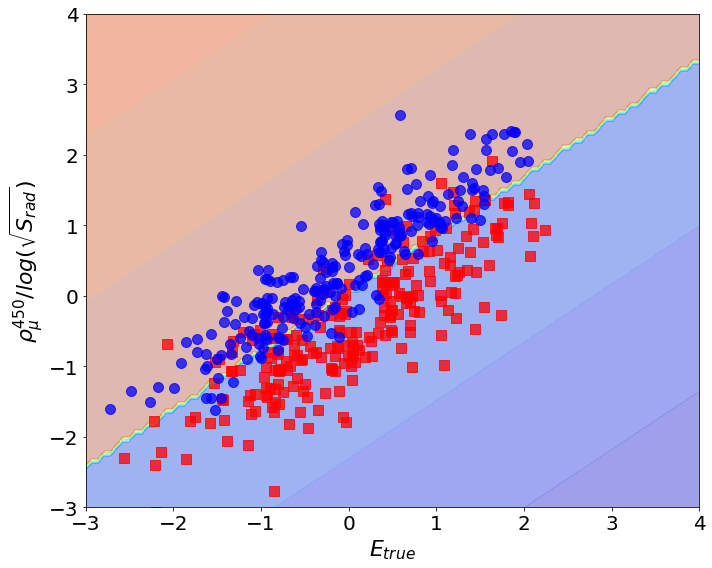

In [60]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    
def plot_predictions(modelo, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = modelo.predict(X).reshape(x0.shape)
    y_decision = modelo.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.3)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)
    
plt.figure(figsize=(10, 8))
plot_predictions(model_svm_3,[-3, 4, -3, 7])
plot_dataset(XX, yy,[-3, 4, -3, 4])
plt.xlabel(r"$E_{true}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / log(\sqrt{S_{rad}})$", fontsize=22)
#save_fig("plano_SVM_plot_best_ obs_2")
plt.show()

In [132]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=10, cv=100, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=100, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,

In [133]:
model_svm_3p = rnd_search_cv.best_estimator_
model_svm_3p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=9.03513192897304, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [134]:
print(accuracy(X_train, y_train, model_svm_3p))
print(crossAccuracy(X_train, y_train, model_svm_3p))

0.8770491803278688
Accuracy:  0.8628826530612246 0.04462594836895032
presicion:  0.8302276841905172 0.05501078722439942
recall:  0.9179999999999999 0.055436650532136436
F1_score:  0.8704012120208897 0.04233743882136437
None


In [135]:
mconfusion(X_train, y_train, model_svm_3p)

Matriz de confusión, 

[[197  47]
 [ 20 224]]
precisión:  0.8265682656826568
exhaustividad:  0.9180327868852459


In [136]:
print(classification_report(y_train, model_svm_3p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       244
           1       0.84      0.93      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [137]:
ypred = cross_val_predict(model_svm_3p, X_train, y_train, cv=5, method="decision_function")

In [138]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

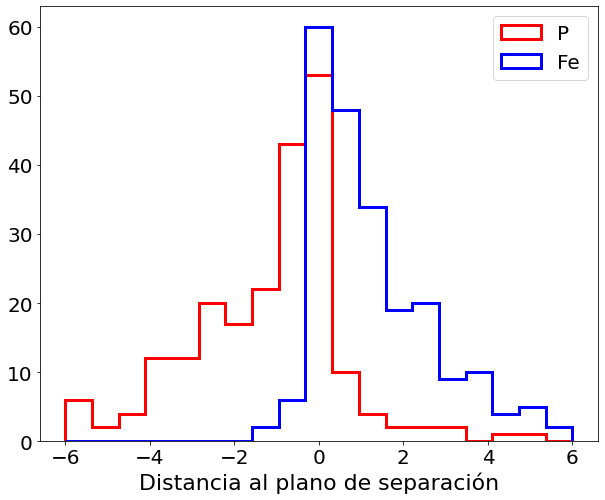

In [139]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [140]:
boostMF(c1_pred, c2_pred)

('0.64', '0.09')

In [438]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.1, 10), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=100, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [439]:
model_svm_4 = rnd_search_cv.best_estimator_
model_svm_4

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=8.903205840497586, break_ties=False, cache_size=200,
                     class_weight=None, coef0=41.27783523445898,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.023324971082976705, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [440]:
print(accuracy(X_train, y_train, model_svm_4))
print(crossAccuracy(X_train, y_train, model_svm_4))

0.8729508196721312
Accuracy:  0.8812074829931973 0.04379053558690313
presicion:  0.8567132401442745 0.048880431435088155
recall:  0.9179999999999999 0.04104063027456246
F1_score:  0.8858750514235689 0.04121243823083535
None


In [441]:
print(crossAccuracy(X_test, y_test, model_svm_4))

Accuracy:  0.8301282051282051 0.11907385594230072
presicion:  0.8126190476190477 0.10120616124935246
recall:  0.869047619047619 0.16296919008235813
F1_score:  0.8328026875085698 0.12084568559032631
None


In [442]:
mconfusion(X_train, y_train, model_svm_4)

Matriz de confusión, 

[[206  38]
 [ 20 224]]
precisión:  0.8549618320610687
exhaustividad:  0.9180327868852459


In [443]:
print(classification_report(y_train, model_svm_4.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [444]:
ypred = cross_val_predict(model_svm_4, X_train, y_train, cv=5, method="decision_function")

In [445]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

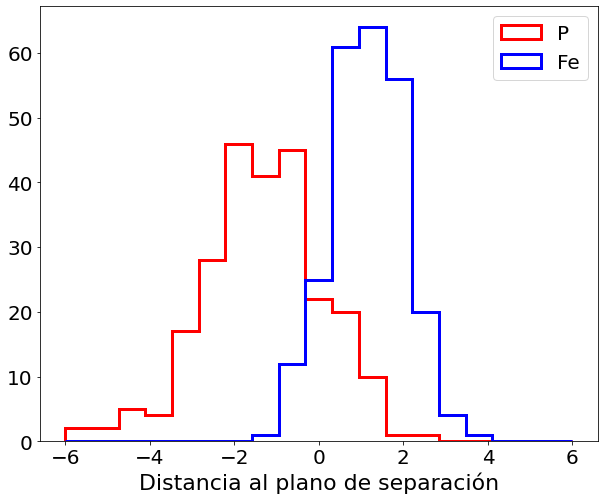

In [446]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [447]:
boostMF(c1_pred, c2_pred)

('1.54', '0.08')

In [448]:
svcP=model_svm_4.named_steps['svm_clf']

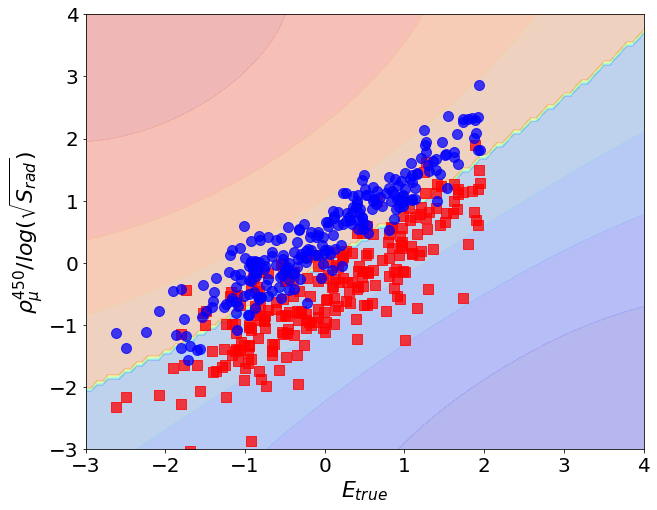

In [449]:
def plot_dataset(X, y, axes):
    plt.plot(XX[yy==0, 0], XX[yy==0, 1], "rs", markersize=10, alpha=0.75, label="P")
    plt.plot(XX[yy==1, 0], XX[yy==1, 1], "bo", markersize=10, alpha=0.75, label="Fe")

    #plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", markersize=10, alpha=0.75)
    #plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ro", markersize=10, alpha=0.75)
    plt.axis(axes)
    #plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=22)
    plt.ylabel(r"$x_2$", fontsize=22, rotation=90)
    


#plot_dataset(X, y, [-6, 6, -1, 7])
#plot_dataset(XX, y, [-3, 4, -3, 7])
#plt.show()

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model_svm_4.predict(X).reshape(x0.shape)
    y_decision = model_svm_4.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.jet, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.jet, alpha=0.1)

plt.figure(figsize=(10, 8))
plot_predictions(model_svm_4,[-3, 4, -3, 7])
plot_dataset(XX, y,[-3, 4, -3, 4])
plt.xlabel(r"$E_{true}$", fontsize=22)
plt.ylabel(r"$\rho^{450}_{\mu} / log(\sqrt{S_{rad}})$", fontsize=22)
plt.show()

## Variables individuales + Energía

In [152]:
#Features

df_train_2 = df_train[["MC energy", "LogSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "LogSrad", "N_mu_ref", "target"]]

In [153]:
print(df_train_2.shape, df_test_.shape)

(488, 4) (122, 63)


In [154]:
df_train_2.head()

,MC energy,LogSrad,N_mu_ref,target
246,3.824250e+17,3.074320,0.850606,1
76,7.590210e+17,3.352450,1.114180,1
171,6.116010e+17,3.271228,1.146870,1
191,3.842740e+17,3.122918,0.612265,1
75,9.452550e+17,3.448698,1.232080,1


In [155]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC energy   -0.005095
LogSrad     -0.060095
Name: target, dtype: float64

In [156]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 3) (488,) (488, 3) (122,)


In [157]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [158]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [159]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 3) (122, 3) (488,) (122,)


In [160]:
X_train.head()

,MC energy,LogSrad,N_mu_ref
0,-0.324464,-0.187830,0.462230
1,1.092195,1.099993,1.066291
2,0.651643,0.723505,1.133262
3,-0.314309,0.036905,-0.224563
4,1.534527,1.546554,1.301173


In [161]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [162]:
model_Log_5 = rnd_search_cv.best_estimator_
model_Log_5

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.8295583706437137, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [163]:
print(accuracy(X_train, y_train, model_Log_5))
print(crossAccuracy(X_train, y_train, model_Log_5))

0.8729508196721312
Accuracy:  0.8750425170068027 0.044561575665063274
presicion:  0.8581392627861893 0.04973910364398819
recall:  0.9016666666666666 0.04221637386396685
F1_score:  0.8788166748121256 0.04168377054807721
None


In [164]:
mconfusion(X_train, y_train, model_Log_5)

Matriz de confusión, 

[[207  37]
 [ 24 220]]
precisión:  0.8560311284046692
exhaustividad:  0.9016393442622951


In [165]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       244
           1       0.86      0.90      0.88       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [166]:
ypred = cross_val_predict(model_Log_5, X_train, y_train, cv=5, method="decision_function")

In [167]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

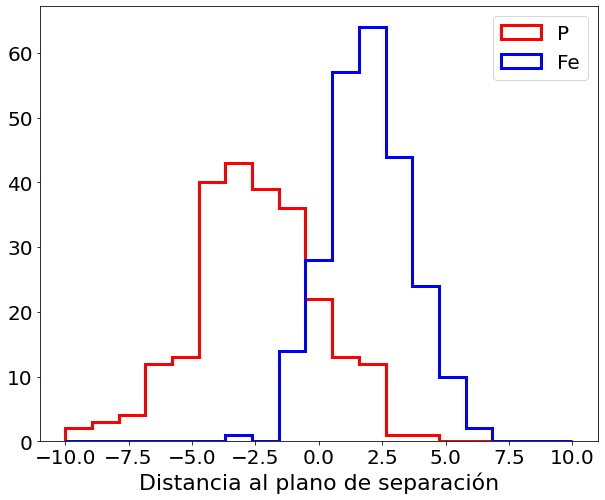

In [168]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [169]:
boostMF(c1_pred, c2_pred)

('1.50', '0.08')

In [170]:
from sklearn.preprocessing import PolynomialFeatures

In [171]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 19)

In [172]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 19)

In [173]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [174]:
model_Log_6 = rnd_search_cv.best_estimator_
model_Log_6

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.2654504193980076, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [175]:
print(accuracy(X_poly2, y_train, model_Log_6))
print(crossAccuracy(X_poly2, y_train, model_Log_6))

0.8770491803278688
Accuracy:  0.8689200680272109 0.054394541047094104
presicion:  0.8554062199669396 0.05225315848563704
recall:  0.8896666666666666 0.0628127729402583
F1_score:  0.8716360889509467 0.053354613745262736
None


In [176]:
mconfusion(X_poly2, y_train, model_Log_6)

Matriz de confusión, 

[[207  37]
 [ 27 217]]
precisión:  0.8543307086614174
exhaustividad:  0.889344262295082


In [177]:
print(classification_report(y_train, model_Log_6.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       244
           1       0.86      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [178]:
ypred = cross_val_predict(model_Log_6, X_poly2, y_train, cv=5, method="decision_function")

In [179]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

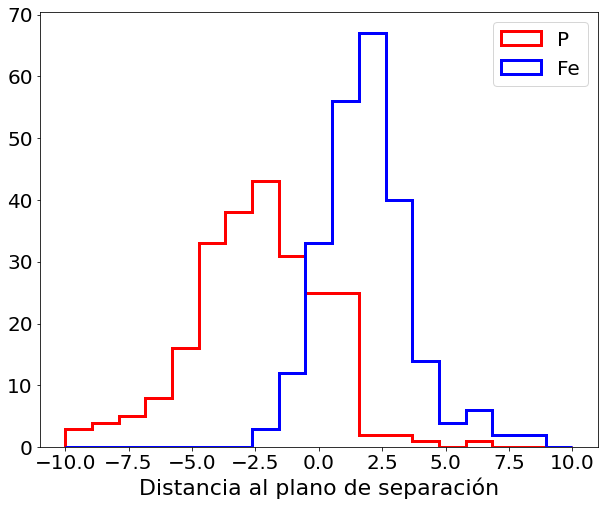

In [180]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [181]:
boostMF(c1_pred, c2_pred)

('1.19', '0.09')

## SVM Energia

In [182]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [183]:
model_svm_5 = rnd_search_cv.best_estimator_
model_svm_5

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=1.2361802972520552, break_ties=False, cache_size=200,
                     class_weight=None, coef0=63.6483376897309,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.011007648954718062, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [184]:
print(accuracy(X_train, y_train, model_svm_5))
print(crossAccuracy(X_train, y_train, model_svm_5))

0.875
Accuracy:  0.8791241496598639 0.041709183673469395
presicion:  0.8585413090158216 0.04422020437237064
recall:  0.9098333333333333 0.048174739807865664
F1_score:  0.8828586605791788 0.04053127253516133
None


In [185]:
mconfusion(X_train, y_train, model_svm_5)

Matriz de confusión, 

[[207  37]
 [ 22 222]]
precisión:  0.8571428571428571
exhaustividad:  0.9098360655737705


In [186]:
print(classification_report(y_train, model_svm_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [187]:
ypred = cross_val_predict(model_svm_5, X_train, y_train, cv=5, method="decision_function")

In [188]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

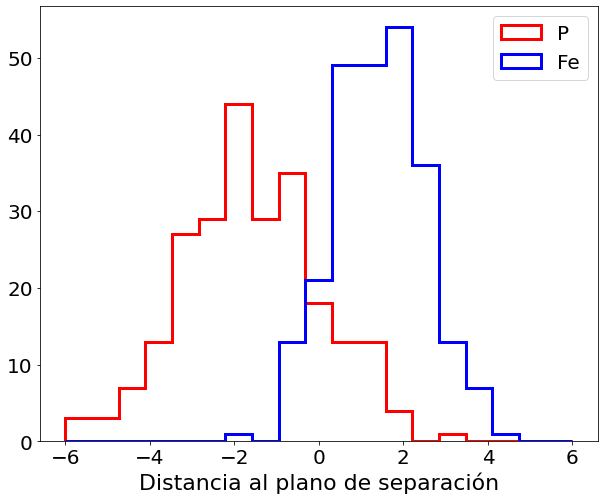

In [189]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [190]:
boostMF(c1_pred, c2_pred)

('1.50', '0.08')

In [191]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [192]:
model_svm_5p = rnd_search_cv.best_estimator_
model_svm_5p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=7.300019368150913, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [193]:
print(accuracy(X_train, y_train, model_svm_5p))
print(crossAccuracy(X_train, y_train, model_svm_5p))

0.8729508196721312
Accuracy:  0.8690051020408163 0.040932396791073355
presicion:  0.8377667872412999 0.04484154713622983
recall:  0.9179999999999999 0.055436650532136436
F1_score:  0.8750482469032189 0.04033432647712239
None


In [194]:
mconfusion(X_train, y_train, model_svm_5p)

Matriz de confusión, 

[[200  44]
 [ 20 224]]
precisión:  0.835820895522388
exhaustividad:  0.9180327868852459


In [195]:
print(classification_report(y_train, model_svm_5p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       244
           1       0.83      0.93      0.88       244

    accuracy                           0.87       488
   macro avg       0.88      0.87      0.87       488
weighted avg       0.88      0.87      0.87       488



In [196]:
ypred = cross_val_predict(model_svm_5p, X_train, y_train, cv=5, method="decision_function")

In [197]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

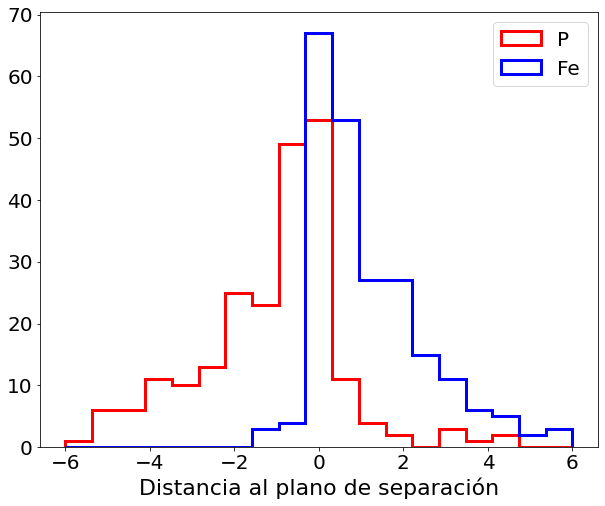

In [198]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [199]:
boostMF(c1_pred, c2_pred)

('0.71', '0.07')

In [200]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [201]:
model_svm_6 = rnd_search_cv.best_estimator_
model_svm_6

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=26.637253501928218, break_ties=False, cache_size=200,
                     class_weight=None, coef0=91.03393171650599,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.03598719027868818, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [202]:
print(accuracy(X_train, y_train, model_svm_6))
print(crossAccuracy(X_train, y_train, model_svm_6))

0.8790983606557377
Accuracy:  0.8791666666666667 0.038343551897825505
presicion:  0.8590864595174941 0.04639517593448222
recall:  0.9098333333333335 0.03576505122167293
F1_score:  0.8832116783820446 0.0359101270721714
None


In [203]:
mconfusion(X_train, y_train, model_svm_6)

Matriz de confusión, 

[[207  37]
 [ 22 222]]
precisión:  0.8571428571428571
exhaustividad:  0.9098360655737705


In [204]:
print(classification_report(y_train, model_svm_6.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [205]:
ypred = cross_val_predict(model_svm_6, X_train, y_train, cv=5, method="decision_function")

In [206]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

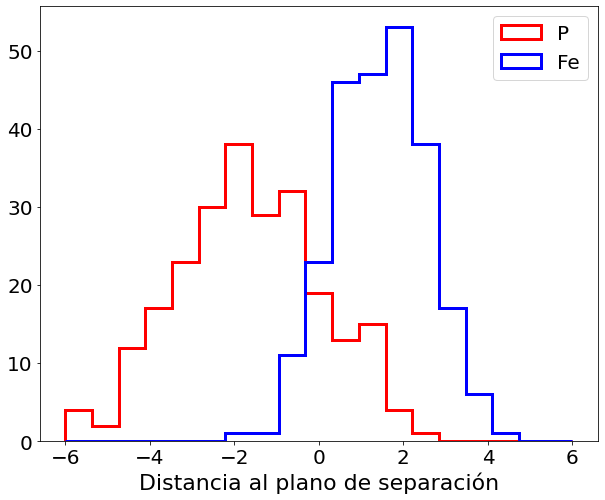

In [207]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [208]:
boostMF(c1_pred, c2_pred)

('1.53', '0.08')

## Sumando el ángulo cenital

In [209]:
#Features

df_train_2 = df_train[["MC energy", "MC zenith", "LogSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "MC zenith", "LogSrad", "N_mu_ref", "target"]]

In [210]:
print(df_train_2.shape, df_test_.shape)

(488, 5) (122, 63)


In [211]:
df_train_2.head()

,MC energy,MC zenith,LogSrad,N_mu_ref,target
246,3.824250e+17,50.0277,3.074320,0.850606,1
76,7.590210e+17,50.6696,3.352450,1.114180,1
171,6.116010e+17,40.6307,3.271228,1.146870,1
191,3.842740e+17,53.6568,3.122918,0.612265,1
75,9.452550e+17,49.0955,3.448698,1.232080,1


In [212]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target       1.000000
N_mu_ref     0.384449
MC zenith    0.016190
MC energy   -0.005095
LogSrad     -0.060095
Name: target, dtype: float64

In [213]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 4) (488,) (488, 4) (122,)


In [214]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [215]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [216]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 4) (122, 4) (488,) (122,)


In [217]:
X_train.head()

,MC energy,MC zenith,LogSrad,N_mu_ref
0,-0.324464,0.607596,-0.187830,0.462230
1,1.092195,0.757615,1.099993,1.066291
2,0.651643,-1.051059,0.723505,1.133262
3,-0.314309,1.527753,0.036905,-0.224563
4,1.534527,0.398978,1.546554,1.301173


In [218]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.1, 1000)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [219]:
model_Log_7 = rnd_search_cv.best_estimator_
model_Log_7

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=350.0316750626199, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [220]:
print(accuracy(X_train, y_train, model_Log_7))
print(crossAccuracy(X_train, y_train, model_Log_7))

0.875
Accuracy:  0.8709608843537413 0.045076549861593054
presicion:  0.8566129426129425 0.051213701311026816
recall:  0.8935000000000001 0.03745701239791794
F1_score:  0.8743792106102237 0.04233274096763008
None


In [221]:
mconfusion(X_train, y_train, model_Log_7)

Matriz de confusión, 

[[207  37]
 [ 26 218]]
precisión:  0.8549019607843137
exhaustividad:  0.8934426229508197


In [222]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_7.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       244
           1       0.86      0.90      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [223]:
ypred = cross_val_predict(model_Log_7, X_train, y_train, cv=5, method="decision_function")

In [224]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

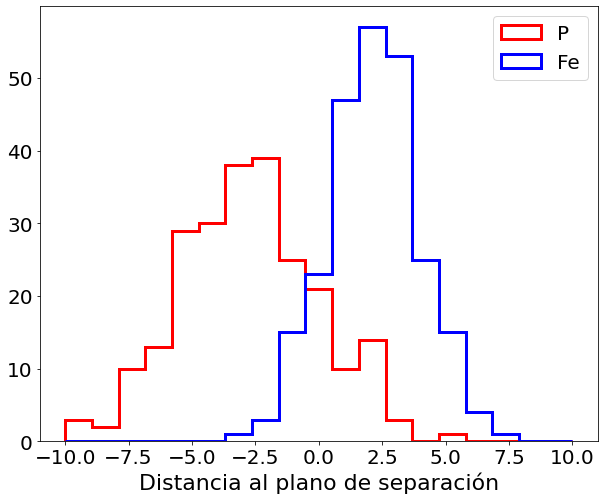

In [225]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [226]:
boostMF(c1_pred, c2_pred)

('1.50', '0.09')

In [227]:
from sklearn.preprocessing import PolynomialFeatures

In [228]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 34)

In [229]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 34)

In [230]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 10)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [231]:
model_Log_8 = rnd_search_cv.best_estimator_
model_Log_8

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=1.8826285911255636, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [232]:
print(accuracy(X_poly2, y_train, model_Log_8))
print(crossAccuracy(X_poly2, y_train, model_Log_8))

0.8790983606557377
Accuracy:  0.8646683673469389 0.0630835620281766
presicion:  0.8479985754985755 0.05777389997140964
recall:  0.8891666666666668 0.0812754233729019
F1_score:  0.8671419980667642 0.06555148902146334
None


In [233]:
mconfusion(X_poly2, y_train, model_Log_8)

Matriz de confusión, 

[[205  39]
 [ 27 217]]
precisión:  0.84765625
exhaustividad:  0.889344262295082


In [234]:
print(classification_report(y_train, model_Log_8.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       244
           1       0.86      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [235]:
ypred = cross_val_predict(model_Log_8, X_poly2, y_train, cv=5, method="decision_function")

In [236]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

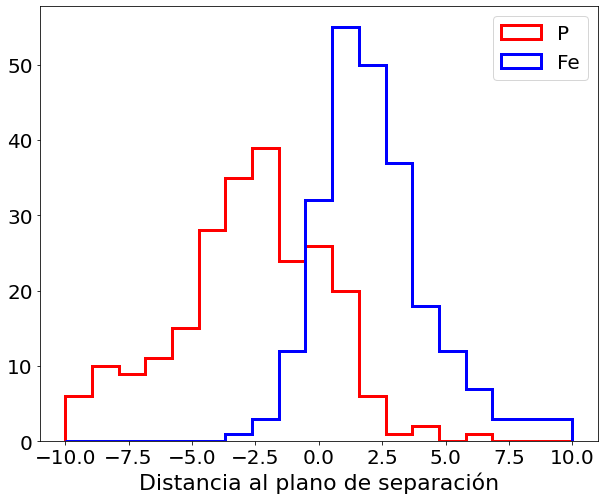

In [237]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [238]:
boostMF(c1_pred, c2_pred)

('1.15', '0.11')

## SVM Energia

In [239]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [240]:
model_svm_7 = rnd_search_cv.best_estimator_
model_svm_7

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=15.32311103190287, break_ties=False, cache_size=200,
                     class_weight=None, coef0=98.6295384901077,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.3826929107457768, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [241]:
print(accuracy(X_train, y_train, model_svm_7))
print(crossAccuracy(X_train, y_train, model_svm_7))

0.875
Accuracy:  0.8791241496598639 0.0436606602544277
presicion:  0.8564771799082143 0.051224518788821574
recall:  0.9136666666666666 0.03929093760369911
F1_score:  0.8836507590941552 0.04099778705871574
None


In [242]:
mconfusion(X_train, y_train, model_svm_7)

Matriz de confusión, 

[[206  38]
 [ 21 223]]
precisión:  0.8544061302681992
exhaustividad:  0.9139344262295082


In [243]:
print(classification_report(y_train, model_svm_7.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [244]:
ypred = cross_val_predict(model_svm_7, X_train, y_train, cv=5, method="decision_function")

In [245]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

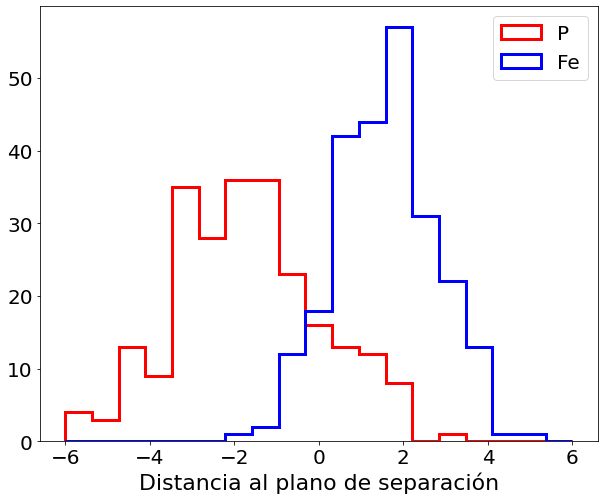

In [246]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [247]:
boostMF(c1_pred, c2_pred)

('1.50', '0.09')

In [248]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.01, 1000)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [249]:
model_svm_7p = rnd_search_cv.best_estimator_
model_svm_7p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=36.576985676530605, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [250]:
print(accuracy(X_train, y_train, model_svm_7p))
print(crossAccuracy(X_train, y_train, model_svm_7p))

0.8688524590163934
Accuracy:  0.8709183673469388 0.038034165848113
presicion:  0.8444273223583568 0.034865094262561895
recall:  0.9098333333333335 0.04760631377360686
F1_score:  0.8755845784854822 0.03734012111279474
None


In [251]:
mconfusion(X_train, y_train, model_svm_7p)

Matriz de confusión, 

[[203  41]
 [ 22 222]]
precisión:  0.844106463878327
exhaustividad:  0.9098360655737705


In [252]:
print(classification_report(y_train, model_svm_7p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       244
           1       0.84      0.91      0.87       244

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488



In [253]:
ypred = cross_val_predict(model_svm_7p, X_train, y_train, cv=5, method="decision_function")

In [254]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

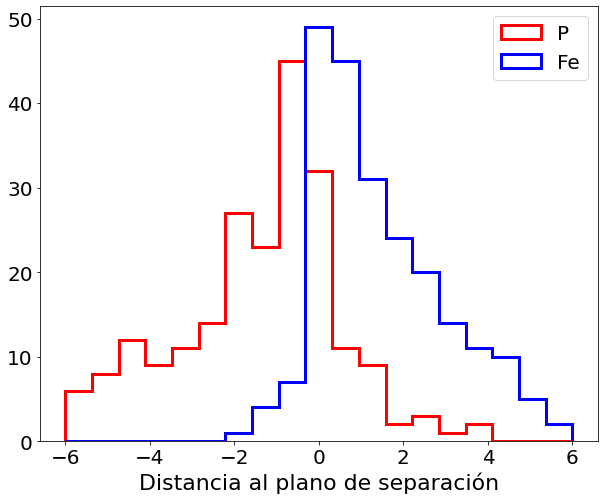

In [255]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [256]:
boostMF(c1_pred, c2_pred)

('0.81', '0.10')

In [257]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [258]:
model_svm_8 = rnd_search_cv.best_estimator_
model_svm_8

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=13.379425851707783, break_ties=False, cache_size=200,
                     class_weight=None, coef0=12.735344706981543,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.004474504495597474, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [259]:
print(accuracy(X_train, y_train, model_svm_8))
print(crossAccuracy(X_train, y_train, model_svm_8))

0.8790983606557377
Accuracy:  0.8769982993197278 0.046237728709643315
presicion:  0.8445238095238097 0.04790366806009366
recall:  0.9259999999999999 0.044410959608336915
F1_score:  0.8830407354919801 0.04307761290096809
None


In [260]:
mconfusion(X_train, y_train, model_svm_8)

Matriz de confusión, 

[[202  42]
 [ 18 226]]
precisión:  0.8432835820895522
exhaustividad:  0.9262295081967213


In [261]:
print(classification_report(y_train, model_svm_8.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       244
           1       0.84      0.93      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [262]:
ypred = cross_val_predict(model_svm_8, X_train, y_train, cv=5, method="decision_function")

In [263]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

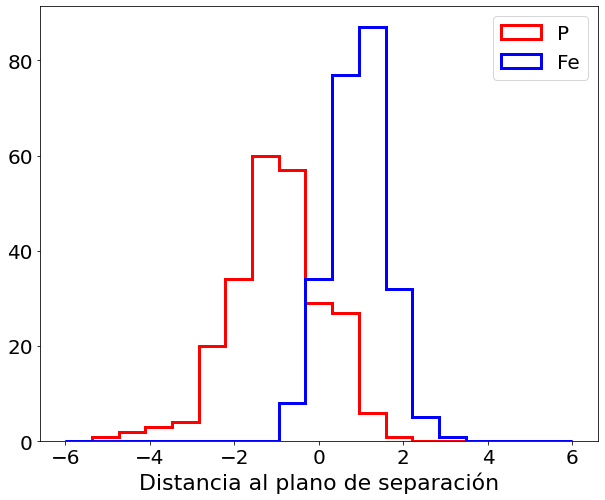

In [264]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [265]:
boostMF(c1_pred, c2_pred)

('1.50', '0.08')

In [266]:
"Stations with Pulse"

'Stations with Pulse'

## Sumando estaciones de Radio

In [267]:
#Features

df_train_2 = df_train[["MC energy", "Stations with Pulse", "MC zenith", "LogSrad", "N_mu_ref", "target"]]
df_test_2 = df_test[["MC energy", "Stations with Pulse", "MC zenith", "LogSrad", "N_mu_ref", "target"]]

In [268]:
print(df_train_2.shape, df_test_.shape)

(488, 6) (122, 63)


In [269]:
df_train_2.head()

,MC energy,Stations with Pulse,MC zenith,LogSrad,N_mu_ref,target
246,3.824250e+17,5,50.0277,3.074320,0.850606,1
76,7.590210e+17,6,50.6696,3.352450,1.114180,1
171,6.116010e+17,7,40.6307,3.271228,1.146870,1
191,3.842740e+17,31,53.6568,3.122918,0.612265,1
75,9.452550e+17,9,49.0955,3.448698,1.232080,1


In [270]:
corr_matrix = df_train_2.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
N_mu_ref               0.384449
Stations with Pulse    0.031046
MC zenith              0.016190
MC energy             -0.005095
LogSrad               -0.060095
Name: target, dtype: float64

In [271]:
# eliminamos el target que se usa para clasificar
df_train_aux = df_train_2.drop("target", axis=1) 
df_train_labels = df_train_2["target"].copy()

df_test_aux = df_test_2.drop("target", axis=1) 
df_test_labels = df_test_2["target"].copy()

print(df_train_aux.shape, df_train_labels.shape, df_train_aux.shape, df_test_labels.shape)

(488, 5) (488,) (488, 5) (122,)


In [272]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

#scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer(method='box-cox')
#scaler = PowerTransformer(method='yeo-johnson')
#scaler = StandardScaler()

h_train = scaler.fit_transform(df_train_aux)
h_test = scaler.fit_transform(df_test_aux)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_aux.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_aux.columns)

In [273]:
X_train=df_prep_train.copy()
y_train=df_train_labels.copy()

X_test=df_prep_test.copy()
y_test=df_test_labels.copy()

In [274]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(488, 5) (122, 5) (488,) (122,)


In [275]:
X_train.head()

,MC energy,Stations with Pulse,MC zenith,LogSrad,N_mu_ref
0,-0.324464,-1.310774,0.607596,-0.187830,0.462230
1,1.092195,-0.712103,0.757615,1.099993,1.066291
2,0.651643,-0.284582,-1.051059,0.723505,1.133262
3,-0.314309,1.699532,1.527753,0.036905,-0.224563
4,1.534527,0.285287,0.398978,1.546554,1.301173


In [276]:
logi_reg_1 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, penalty='l1', solver='liblinear', 
                                        tol=1e-8, max_iter=10000))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(logi_reg_1, param_distributions, n_iter=300, cv=10)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                                         

In [277]:
model_Log_9 = rnd_search_cv.best_estimator_
model_Log_9

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=38.556966528533266, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=123,
                                    solver='liblinear', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [278]:
print(accuracy(X_train, y_train, model_Log_9))
print(crossAccuracy(X_train, y_train, model_Log_9))

0.875
Accuracy:  0.8709608843537413 0.045076549861593054
presicion:  0.8566129426129425 0.051213701311026816
recall:  0.8935000000000001 0.03745701239791794
F1_score:  0.8743792106102237 0.04233274096763008
None


In [279]:
mconfusion(X_train, y_train, model_Log_9)

Matriz de confusión, 

[[207  37]
 [ 26 218]]
precisión:  0.8549019607843137
exhaustividad:  0.8934426229508197


In [280]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model_Log_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       244
           1       0.86      0.90      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [281]:
ypred = cross_val_predict(model_Log_9, X_train, y_train, cv=5, method="decision_function")

In [282]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

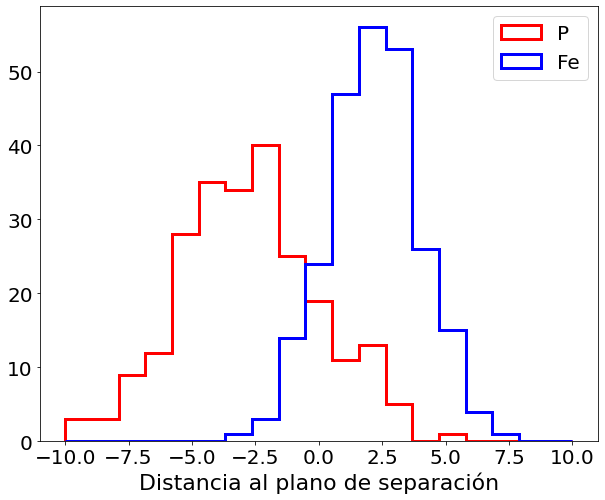

In [283]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [284]:
boostMF(c1_pred, c2_pred)

('1.48', '0.08')

In [285]:
from sklearn.preprocessing import PolynomialFeatures

In [286]:
poly2 = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly2 = poly2.fit_transform(X_train)
X_poly2.shape

(488, 55)

In [287]:
X_poly2_test = poly2.fit_transform(X_test)
X_poly2_test.shape

(122, 55)

In [288]:
model_Log_2 = Pipeline([
        ("logi_clf", LogisticRegression(random_state=123, tol=1e-8, max_iter=10000, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(model_Log_2, param_distributions, n_iter=200, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_poly2, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('logi_clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=10000,
                                                                 multi_class='auto',
                                                                 n_jobs=-1,
                                                                 penalty='l2',
                                           

In [289]:
model_Log_10 = rnd_search_cv.best_estimator_
model_Log_10

Pipeline(memory=None,
         steps=[('logi_clf',
                 LogisticRegression(C=0.12204960369620708, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=1e-08, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [290]:
print(accuracy(X_poly2, y_train, model_Log_10))
print(crossAccuracy(X_poly2, y_train, model_Log_10))

0.8831967213114754
Accuracy:  0.8770408163265305 0.05055799521070868
presicion:  0.8521664167916041 0.06002173042964172
recall:  0.9178333333333333 0.05259937684463995
F1_score:  0.8825847165859682 0.04700497218200031
None


In [291]:
mconfusion(X_poly2, y_train, model_Log_10)

Matriz de confusión, 

[[204  40]
 [ 20 224]]
precisión:  0.8484848484848485
exhaustividad:  0.9180327868852459


In [292]:
print(classification_report(y_train, model_Log_10.predict(X_poly2)))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       244
           1       0.85      0.93      0.89       244

    accuracy                           0.88       488
   macro avg       0.89      0.88      0.88       488
weighted avg       0.89      0.88      0.88       488



In [293]:
ypred = cross_val_predict(model_Log_10, X_poly2, y_train, cv=5, method="decision_function")

In [294]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

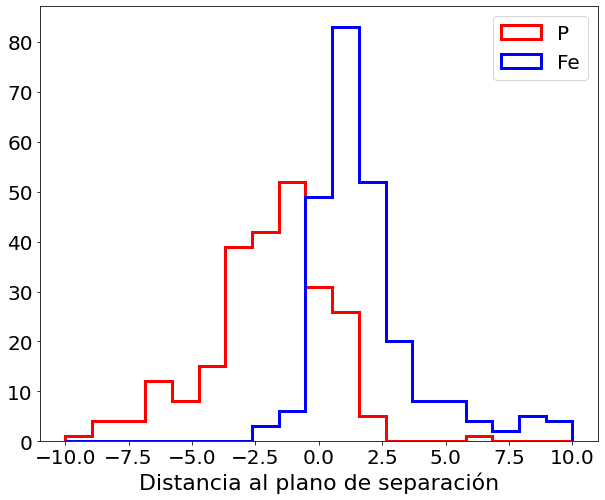

In [295]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-10, 10, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [296]:
boostMF(c1_pred, c2_pred)

('1.00', '0.11')

## SVM Energia

In [297]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="linear", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='linear', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n...
               

In [298]:
model_svm_9 = rnd_search_cv.best_estimator_
model_svm_9

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=3.190480219867143, break_ties=False, cache_size=200,
                     class_weight=None, coef0=46.86030554242891,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.000146946496417938, kernel='linear', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [299]:
print(accuracy(X_train, y_train, model_svm_9))
print(crossAccuracy(X_train, y_train, model_svm_9))

0.875
Accuracy:  0.8729591836734694 0.04511645453597615
presicion:  0.8485925645235989 0.048075325618903944
recall:  0.9094999999999999 0.04867722488209679
F1_score:  0.8775181060329308 0.04391342677311325
None


In [300]:
mconfusion(X_train, y_train, model_svm_9)

Matriz de confusión, 

[[204  40]
 [ 22 222]]
precisión:  0.8473282442748091
exhaustividad:  0.9098360655737705


In [301]:
print(classification_report(y_train, model_svm_9.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.87       488
weighted avg       0.88      0.88      0.87       488



In [302]:
ypred = cross_val_predict(model_svm_9, X_train, y_train, cv=5, method="decision_function")

In [303]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

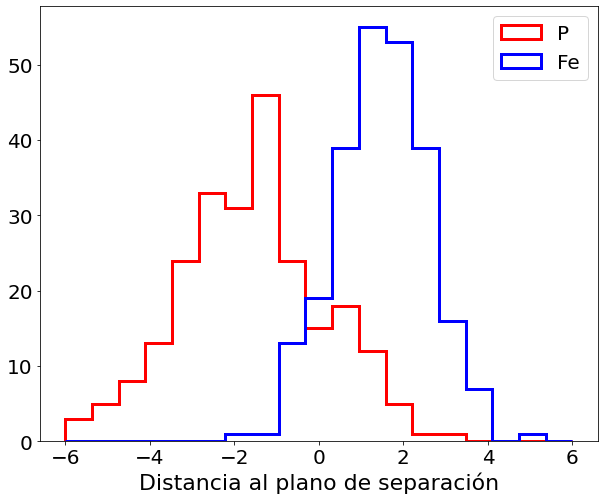

In [304]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [305]:
boostMF(c1_pred, c2_pred)

('1.49', '0.09')

In [306]:
poly_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="poly", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__C": uniform(0.01, 100)}
rnd_search_cv = RandomizedSearchCV(poly_svm, param_distributions, n_iter=100, cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='poly', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,

In [307]:
model_svm_9p = rnd_search_cv.best_estimator_
model_svm_9p

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=44.61747992362089, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=True,
                     random_state=369, shrinking=True, tol=1e-08,
                     verbose=False))],
         verbose=False)

In [308]:
print(accuracy(X_train, y_train, model_svm_9p))
print(crossAccuracy(X_train, y_train, model_svm_9p))

0.8770491803278688
Accuracy:  0.8708758503401361 0.05770234546409651
presicion:  0.8521587020897365 0.04842856213423518
recall:  0.8975000000000002 0.08659371930008677
F1_score:  0.8728554857840571 0.061261714763307884
None


In [309]:
mconfusion(X_train, y_train, model_svm_9p)

Matriz de confusión, 

[[206  38]
 [ 25 219]]
precisión:  0.8521400778210116
exhaustividad:  0.8975409836065574


In [310]:
print(classification_report(y_train, model_svm_9p.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       244
           1       0.85      0.91      0.88       244

    accuracy                           0.88       488
   macro avg       0.88      0.88      0.88       488
weighted avg       0.88      0.88      0.88       488



In [311]:
ypred = cross_val_predict(model_svm_9p, X_train, y_train, cv=5, method="decision_function")

In [312]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

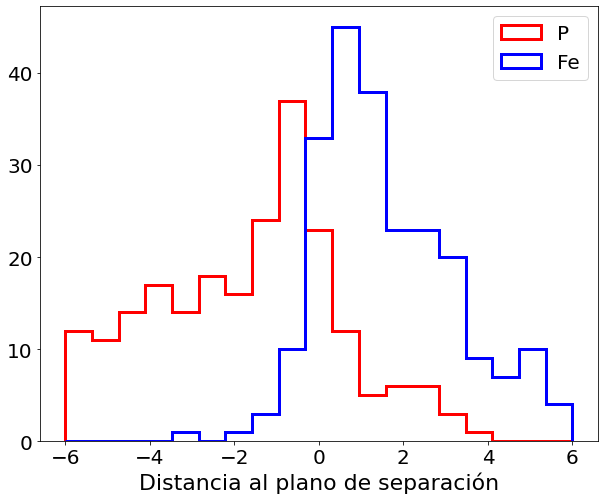

In [313]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [314]:
boostMF(c1_pred, c2_pred)

('0.91', '0.09')

In [315]:
rbf_svm = Pipeline([
        ("svm_clf", svm.SVC(probability=True, kernel="rbf", tol=1e-8, random_state=369))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(1e-6, 1), "svm_clf__C": uniform(0.01, 100), 
                       "svm_clf__coef0": uniform(1, 100)}
rnd_search_cv = RandomizedSearchCV(rbf_svm, param_distributions, n_iter=300, 
                                   cv=10, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svm_clf',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=True,
                                                  random_state=369,
                                                  shrinking=True, tol=1e-08,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_it...
               

In [316]:
model_svm_10 = rnd_search_cv.best_estimator_
model_svm_10

Pipeline(memory=None,
         steps=[('svm_clf',
                 SVC(C=80.77470636078264, break_ties=False, cache_size=200,
                     class_weight=None, coef0=99.35004254431597,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.0008440920651450243, kernel='rbf', max_iter=-1,
                     probability=True, random_state=369, shrinking=True,
                     tol=1e-08, verbose=False))],
         verbose=False)

In [317]:
print(accuracy(X_train, y_train, model_svm_10))
print(crossAccuracy(X_train, y_train, model_svm_10))

0.8729508196721312
Accuracy:  0.876998299319728 0.048005466432188004
presicion:  0.8443406593406593 0.04850438538443256
recall:  0.9258333333333335 0.048329022796291296
F1_score:  0.8828707249623692 0.04528385914102136
None


In [318]:
mconfusion(X_train, y_train, model_svm_10)

Matriz de confusión, 

[[202  42]
 [ 18 226]]
precisión:  0.8432835820895522
exhaustividad:  0.9262295081967213


In [319]:
print(classification_report(y_train, model_svm_10.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       244
           1       0.84      0.92      0.88       244

    accuracy                           0.87       488
   macro avg       0.88      0.87      0.87       488
weighted avg       0.88      0.87      0.87       488



In [320]:
ypred = cross_val_predict(model_svm_10, X_train, y_train, cv=5, method="decision_function")

In [321]:
label=np.array(y_train)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

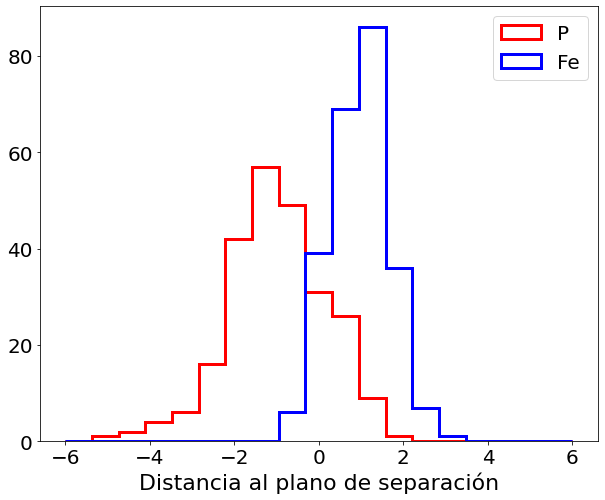

In [322]:
plt.figure(figsize=(10, 8))
bins = np.linspace(-6, 6, 20)
plt.hist(c1_pred, bins, histtype='step', linewidth=3, color='r', label="P");
plt.hist(c2_pred, bins, histtype='step', linewidth=3, color='b', label="Fe");
plt.xlabel("Distancia al plano de separación")
plt.legend(fontsize=20)

In [323]:
boostMF(c1_pred, c2_pred)

('1.49', '0.08')